### Step 1: Data Preparation
#### Load and Explore the Data

In [1]:
import json
import pandas as pd

# Load the JSON data
with open('Sarcasm_Headlines_Dataset.json', 'r') as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)

# Basic exploration
print(df.head())
print(df['is_sarcastic'].value_counts())
# print(df.isnull().sum())

                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  
is_sarcastic
0    14985
1    11724
Name: count, dtype: int64


#### Preprocessing

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

nltk.download('punkt_tab')
nltk.download('stopwords')

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

df['tokens'] = df['headline'].apply(preprocess_text)
print(df['tokens'])

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jerome/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jerome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0        [former, versace, store, clerk, sues, secret, ...
1        [roseanne, revival, catches, thorny, political...
2        [mom, starting, fear, sons, web, series, close...
3        [boehner, wants, wife, listen, come, alternati...
4        [jk, rowling, wishes, snape, happy, birthday, ...
                               ...                        
26704                [american, politics, moral, freefall]
26705                          [americas, best, 20, hikes]
26706                                 [reparations, obama]
26707    [israeli, ban, targeting, boycott, supporters,...
26708                       [gourmet, gifts, foodie, 2014]
Name: tokens, Length: 26709, dtype: object


### Step 2: Feature Engineering

In [3]:
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, words as english_words
from textblob import TextBlob

def extract_features(text):
    features = {}
    tokens = word_tokenize(text.lower())
    words = [word for word in tokens if word.isalpha()]
    word_count = len(words)
    
    # 1. Basic statistics
    features['num_words'] = word_count
    features['avg_word_length'] = sum(len(word) for word in words)/word_count if word_count else 0
    
    # 2. Lexical Diversity
    features['lexical_diversity'] = len(set(words))/word_count if word_count else 0
    
    # 3. Stop Words
    stop_words = set(stopwords.words('english'))
    features['stop_words_ratio'] = sum(1 for word in words if word in stop_words)/word_count if word_count else 0
    
    # 4. Word length features
    features['lengthy_words_ratio'] = sum(1 for word in words if len(word) > 2)/word_count if word_count else 0
    features['two_letter_words_ratio'] = sum(1 for word in words if len(word) == 2)/word_count if word_count else 0
    
    # 5. Sentiment
    sentiment = TextBlob(text).sentiment
    features['polarity'] = sentiment.polarity
    features['subjectivity'] = sentiment.subjectivity
    
    # 6. POS tags - only adjectives
    pos_tags = pos_tag(words)
    features['adjectives_ratio'] = sum(1 for word, tag in pos_tags if tag.startswith('JJ'))/word_count if word_count else 0
    
    return features

# Apply the feature extraction
print("Extracting features...")
features = df['headline'].apply(extract_features)
feature_df = pd.DataFrame(features.tolist())
final_df = pd.concat([feature_df, df['is_sarcastic']], axis=1)



Extracting features...


### Step 3: Exploratory Data Analysis (EDA)

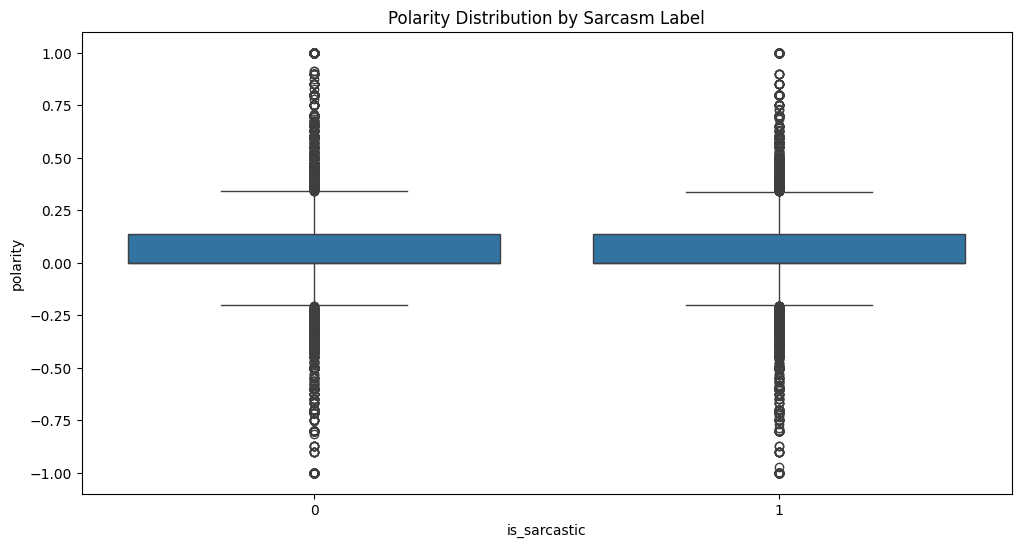

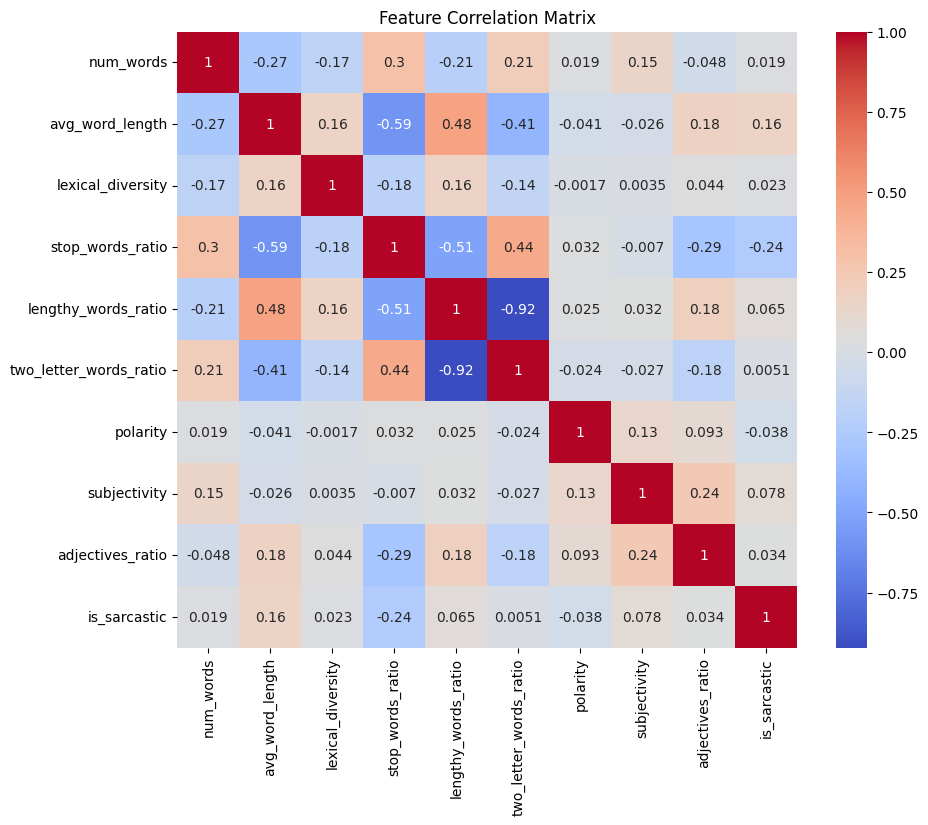

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compare features between sarcastic and non-sarcastic headlines
plt.figure(figsize=(12, 6))
sns.boxplot(x='is_sarcastic', y='polarity', data=final_df)
plt.title('Polarity Distribution by Sarcasm Label')
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(final_df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

### Step 4: Model Building
#### Baseline Model

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

X = final_df.drop('is_sarcastic', axis=1)
y = final_df['is_sarcastic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.69      0.68      2996
           1       0.58      0.55      0.56      2346

    accuracy                           0.63      5342
   macro avg       0.62      0.62      0.62      5342
weighted avg       0.63      0.63      0.63      5342

Accuracy: 0.6289779108947959


#### Feature Importance Analysis

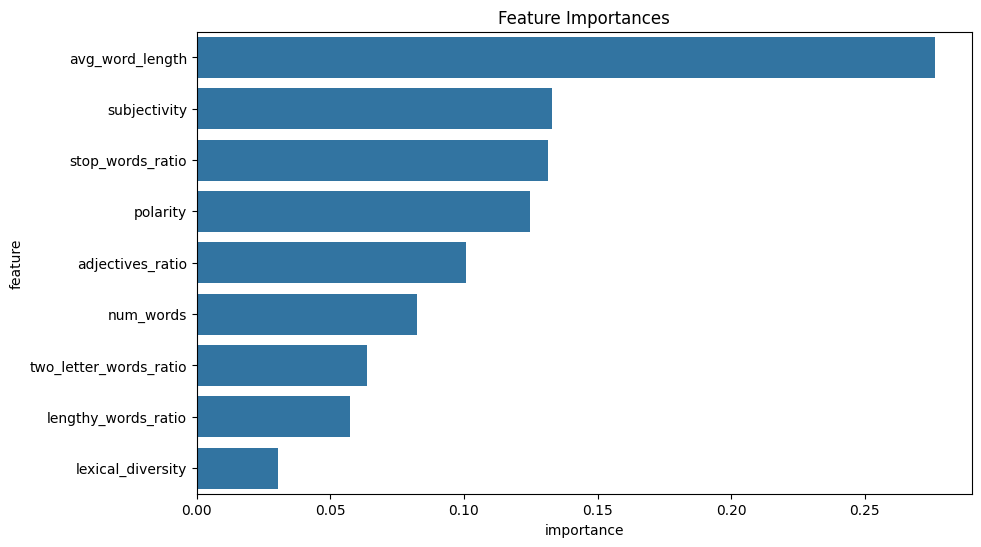

In [6]:
# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Create dataframe
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

### Step 5: Experimentation
#### Ablation Study

In [7]:
# Test removing each feature one at a time
base_accuracy = accuracy_score(y_test, y_pred)
results = []

for feature in X.columns:
    X_ablated = X.drop(feature, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X_ablated, y, test_size=0.2, random_state=42)
    
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    results.append({'feature_removed': feature, 'accuracy': acc, 'difference': base_accuracy - acc})

results_df = pd.DataFrame(results).sort_values('difference', ascending=False)
print(results_df)

          feature_removed  accuracy  difference
3        stop_words_ratio  0.605578    0.023399
6                polarity  0.617559    0.011419
7            subjectivity  0.623924    0.005054
8        adjectives_ratio  0.626357    0.002621
4     lengthy_words_ratio  0.626544    0.002434
5  two_letter_words_ratio  0.626544    0.002434
0               num_words  0.627480    0.001498
1         avg_word_length  0.636091   -0.007113
2       lexical_diversity  0.637589   -0.008611
